# Home Credit Default Risk
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.<br>

**Home Credit** strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data including telco and transactional information to predict their clients' repayment abilities.

## Looking at the Big Picture

There are 7 different sources of data:

- **application_train/application_test**: The main training and testing data with information about each loan application at Home Credit. <br>Every loan has its own row and is identified by the feature SK_ID_CURR.<br> The training application data comes with the TARGET indicating ( **0**: the loan was repaid or **1**: the loan was not repaid).<br>
- **bureau**: Data concerning client's previous credits from other financial institutions.<br> Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.<br>
- **bureau_balance**: Monthly data about the previous credits in bureau. <br>Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
- **previous_application**: Previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
- **POS_CASH_BALANCE**: Monthly data about previous point of sale or cash loans clients have had with Home Credit. <br>Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
- **credit_card_balance**: Monthly data about previous credit cards clients have had with Home Credit. <br>Each row is one month of a credit card balance, and a single credit card can have many rows.
- **installments_payment**: Payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.<br>

This diagram shows how all of the data is related:
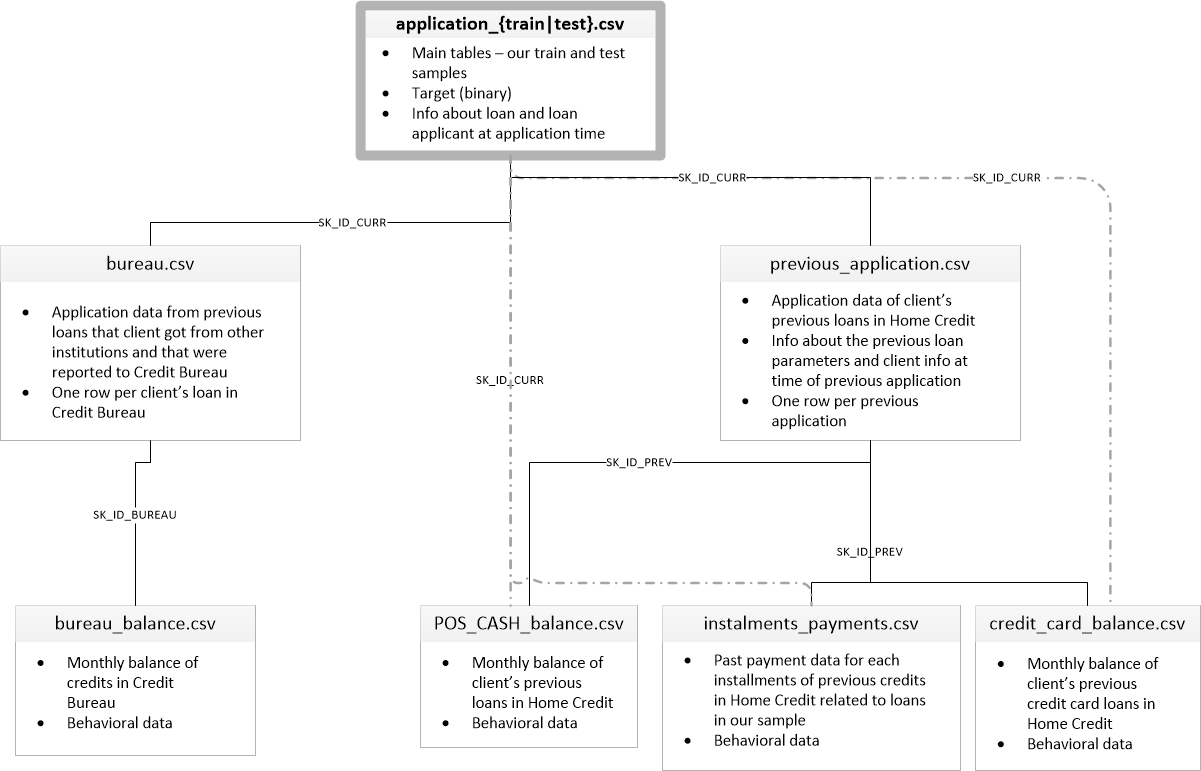




## Our Aim:
Our objective is to predict how capable each applicant is of repaying a loan.

## The Objective in Business terms.
Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience so we need to Predict whether or not a client will repay a loan or have difficulty in repaying.

## Frame of the problem
It is clearly a typical **supervised learning task** since we are given labeled training examples (each instance comes with the expected output).<br>
Moreover, it is also a typical **Classification task**, since we are asked to predict a class.<br>
It is also a univariate classification problem since we are only trying to predict a single class for each district.


## Selecting Preformance Measure
A typical performance measure for classification problems is the Area under the ROC Curve (AUC/ROC). <br> 
It is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:
- True Positive Rate
- False Positive Rate

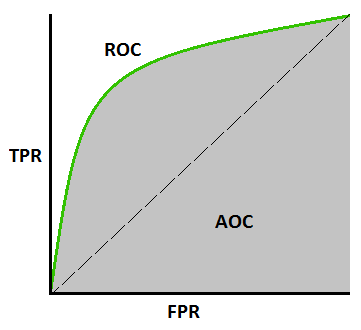

## Importing common libraries

In [1]:
import sklearn
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Data
First, we can list all the available data files. There are a total of 8 files:
- 1 main file for training (with target) 
- 1 main file for testing (without the target)
- And 6 other files containing additional information about each loan

In [758]:
# Reading the data files into our environment.
application_train = pd.read_csv('./data/application_train.csv')
application_test = pd.read_csv('./data/application_test.csv')
POS_CASH_balance = pd.read_csv('./data/POS_CASH_balance.csv')
bureau_balance = pd.read_csv('./data/bureau_balance.csv')
previous_application = pd.read_csv('./data/previous_application.csv')
installments_payments = pd.read_csv('./data/installments_payments.csv')
credit_card_balance = pd.read_csv('./data/credit_card_balance.csv')
bureau = pd.read_csv('./data/bureau.csv')

# this data file contains the every feature description.
# It neads a different ecoding because it has some special characters in it. 
col_des = pd.read_csv('./data/HomeCredit_columns_description.csv', encoding='latin1')

In [57]:
# I described the data earlier, but a sanity check  
print('Size of application_train data', application_train.shape)
print('Size of application_test data', application_test.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


- As we can see the main dataset we have is application_train with 122 features (i will see if we can reduce the dimentionality without affecting the model performance later on)
- All other history data are in another file I will figure out a way to put the toghter when feeding them to the model.

## Glimpse of the data 
Because we have more than a few datasets I will write a function that will give us a glimpse look on what we are dealing with.

In [85]:
# defining the function.
def glimpse_of_data(data):
    """
    This function accepts a dataset, and returns a quick look at it.
    
    INPUTS: 
        data: data variable name.
    RETURNS: 
        A quick look at the shape, head, and column types it has.
    """
    # printing the shape of the data
    print('The shape of the dataset is: ',data.shape)
    print('-------------------------------------------------------')
    print('Count of column types the dataset has is :\n ', data.dtypes.value_counts())
    print('-------------------------------------------------------')

    # taking a quick look on the main dataset we have with the head function which shows a few records of our data
    return data.head(8)


#### Now let us look at the main dataset we have.

In [86]:
glimpse_of_data(application_train)

The shape of the dataset is:  (307511, 122)
-------------------------------------------------------
Count of column types the dataset has is :
  float64    65
int64      41
object     16
dtype: int64
-------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


From the table above can observe the the columns names are a little ambiguous, but we are provided with a file that have a describtion for all our features

In [62]:
# Listing all columns we have
application_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

So if we want to know what a column mean we can look at the file or call this function for simplicity.

In [66]:
# defining the function.
def col_describtion(col):
    """
    This function accepts astring column name, and returns its describtion.
    
    INPUTS: 
        col: string column name.
    RETURNS: 
        Description of the column.
    """
    return col_des[col_des.Row == col].Description.values

# Sanity check on column describtion

# col_describtion('SK_ID_CURR')
col_describtion('TARGET')
# col_describtion('NAME_CONTRACT_TYPE')
# col_describtion('FLAG_OWN_REALTY')

array(['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'],
      dtype=object)

In [92]:
# let us take a ook at the target column
application_train.TARGET.value_counts() / len(application_train) * 100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

#### Check data unbalance
TARGET value **0** means loan is repaid, value **1** means loan is not repaid.

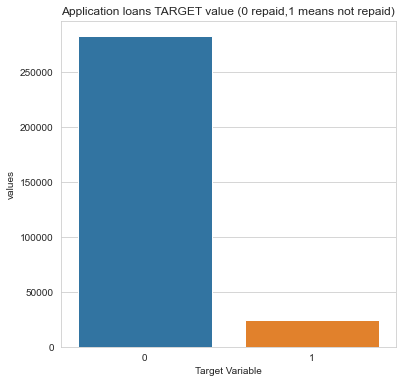

In [698]:
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'Target Variable': temp.index,
                   'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Application loans TARGET value (0 repaid,1 means not repaid)')
sns.set_color_codes("pastel")
sns.barplot(x = 'Target Variable', y="values", data=df)
plt.show()

- **92%** of the loans are repaid, **8%** are not repaid.
- Looks like an unbalanced dataset which will make our model parametrs are **baised** towards the negative class.
- There are multiple techniques to deal with imbalanced data.
   - In our case we could try undersampling by reducing the size of the majority class (0).
   - since The quantity data is quite sufficient, we will keep all samples in the rare class (1) and randomly selecting (without replacment) an equal number of samples in the majority class (0).
- we can not use The accuracy default metric in evaluation, insted we can use **f1_score, or AUC/ROC**. 

---

#### Let us look at another the bureau dataset.


In [87]:
glimpse_of_data(bureau)

The shape of the dataset is:  (1716428, 17)
-------------------------------------------------------
Count of column types the dataset has is :
  float64    8
int64      6
object     3
dtype: int64
-------------------------------------------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN


- This Data is concerning client's previous credits **from other financial institutions**.
- One loan in our sample can have 0,1,2 or more related previous credits in credit bureau

In [95]:
# Looking at some column describtion
col_describtion('DAYS_CREDIT')

array(['How many days before current application did client apply for Credit Bureau credit'],
      dtype=object)

---- 
#### let us look at bureau_balance dataset

In [96]:
glimpse_of_data(bureau_balance)

The shape of the dataset is:  (27299925, 3)
-------------------------------------------------------
Count of column types the dataset has is :
  int64     2
object    1
dtype: int64
-------------------------------------------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C


- Monthly balance of credit about previous credits in bureau.
- Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

In [99]:
# Checking what status column mean and see its values 
col_describtion('STATUS')

array(['Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ] )'],
      dtype=object)

In [102]:
# values of status column 
bureau_balance.STATUS.value_counts() / len(bureau_balance) * 100

C    49.989123
0    27.470797
X    21.283875
1     0.887720
5     0.228594
2     0.085784
3     0.032689
4     0.021418
Name: STATUS, dtype: float64

- As we can see almost **50%** (13646993) of the previously loans are closed or completed.
- In previous loans **27.4%** (7499507) payed their loan in time no  Days Past Due (DPD).
- About **21%** (5810482) of previous loan status are unknown.
- And other previous loans are payed after due at a period from (1:120) days as shown above.

----
#### let us look at the previous_application

In [104]:
glimpse_of_data(previous_application)

The shape of the dataset is:  (1670214, 37)
-------------------------------------------------------
Count of column types the dataset has is :
  object     16
float64    15
int64       6
dtype: int64
-------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


- Previous applications for loans at Home Credit of clients who have loans in the application data.
- Each current loan in the application data can have multiple previous loans.
- Each previous application has one row and is identified by the feature SK_ID_PREV.

In [106]:
previous_application.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [119]:
col_describtion('NAME_CONTRACT_STATUS')

array(['Contract status during the month',
       'Contract status (active signed,...) on the previous credit',
       'Contract status (approved, cancelled, ...) of previous application'],
      dtype=object)

In [122]:
previous_application.NAME_CONTRACT_STATUS.value_counts() / len(previous_application) * 100

Approved        62.074740
Canceled        18.938831
Refused         17.403638
Unused offer     1.582791
Name: NAME_CONTRACT_STATUS, dtype: float64

- About **60%** (1036781) of previous loans are approved.
- **19%** (316319) of previous loans are canceled, or forgiven, and **17.5%** are refused

-----
#### Taking a look at POS_CASH_balance dataset.

In [123]:
glimpse_of_data(POS_CASH_balance)

The shape of the dataset is:  (10001358, 8)
-------------------------------------------------------
Count of column types the dataset has is :
  int64      5
float64    2
object     1
dtype: int64
-------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0


- Monthly balance data about previous point of sale or cash loans clients have had with Home Credit.
- Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

----
#### Taking a look at installments_payments

In [140]:
glimpse_of_data(installments_payments)

The shape of the dataset is:  (13605401, 8)
-------------------------------------------------------
Count of column types the dataset has is :
  float64    5
int64      3
dtype: int64
-------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165


- Payment history for previous loans at Home Credit.
- There is one row for every made payment and one row for every missed payment.

----
#### Taking a look at credit_card_balance

In [143]:
glimpse_of_data(credit_card_balance)

The shape of the dataset is:  (3840312, 23)
-------------------------------------------------------
Count of column types the dataset has is :
  float64    15
int64       7
object      1
dtype: int64
-------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.0,0.0,0.0,4449.105,...,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.0,0.0,0.0,14684.175,...,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.0,0.0,0.0,0.000,...,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0


- Monthly data about previous credit cards clients have had with Home Credit.
- Each row is one month of a credit card balance, and a single credit card can have many rows.

------

### Check for missing data¶


In [188]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
    """
    This function accepts dataframe, and returns dataframe with the missing columns and how much is missing.
    
    INPUTS: 
        df: a dataset.
    RETURNS: 
        Dataframe with the missing columns and how much is missing.
    """
        # Total missing values
    mis_val = df.isnull().sum()
    
       # condition if the data have no missing values
    if mis_val.any() == 0:
        return print("The dataset have no missing values")
    else:
        # Percentage of missing values
        mis_val_percent =  mis_val / len(df) * 100
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        rename_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        sorted_columns = rename_columns[rename_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(sorted_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return sorted_columns

#### Checking for missing values in application_train dataset

In [189]:
# calling the function 
missing_values_table(application_train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


let us see example about what is the nature of columns with almost 70% of its data is missing

In [182]:
col_describtion('COMMONAREA_MEDI')

array(['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor'],
      dtype=object)

May be its wise to drop those column as ther is more specific columns we can see how luxurious ther live is.

###### There are some techniques to deal with missing data:
- I will try to drop columns with more than 50% missing data on preprocessing step and see how it will affect the model.
- Imputing with the column mean, median or mode (it depends on the nature of the column).
- if we have some more time we could take a close look on some columns to best decide what to do with the missing values.

--------

#### Checking for missing values in bureau dataset


In [183]:
missing_values_table(bureau)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


- 70% of the columns have missing values

#### Checking for missing values in bureau_balance dataset


In [190]:
missing_values_table(bureau_balance)

The dataset have no missing values


------

In [191]:
missing_values_table(previous_application)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


- 45% of the columns have missing values.
- there are two columns that have almost 100% missing which are the Interest rate normalized on previous credit.

----

In [195]:
missing_values_table(POS_CASH_balance)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


- Monthly data balance has not much missing from it.

----

In [196]:
missing_values_table(installments_payments)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


- Installments data balance has not much missing from it too.

In [197]:
missing_values_table(credit_card_balance)

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


------

## Data Exploration


Defining a function to easly explore categorical features.

In [744]:
# Declaring the function
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    """
    This function plots the stats of a feature twice,
    first with the whole dataset and the other plot with tha traget value=1 (not repayed).
    
    INPUTS: 
        feature: the feature we want to plot.
        label_rotation(bool): if we want the axis label rotated or not.
        horizontal_layout(bool): if we want the the plot horizontaly or vertically.
        
    RETURNS: 
        plots the stats of a feature.
    """
    # count the unique values of the feature
    temp = application_train[feature].value_counts()
    
    # Putting it in a dataframe
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    # controling the layout
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
        
    # setting the color codes
    sns.set_color_codes("pastel")
    
    # ploting the feature with the whole dataset
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    
    # controling rotation of the label
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    # ploting the feature when the target vslue =1
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    
    # controling rotation of the label
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
       
    # adjusting the plot
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    
    if not (horizontal_layout):
        ax1.set_title('Stats of '+ feature +' with the whole dataset and with the traget value=1 "not repaid"',
              pad=10,fontsize=13.5)
    else: 
        plt.title('Stats of '+ feature +' with the whole dataset and with the traget value=1 "not repaid"',
             loc='right', pad=10,fontsize=15)
    return plt.show()

#### Exploring NAME_CONTRACT_TYPE
It is an identification if loan is cash or revolving

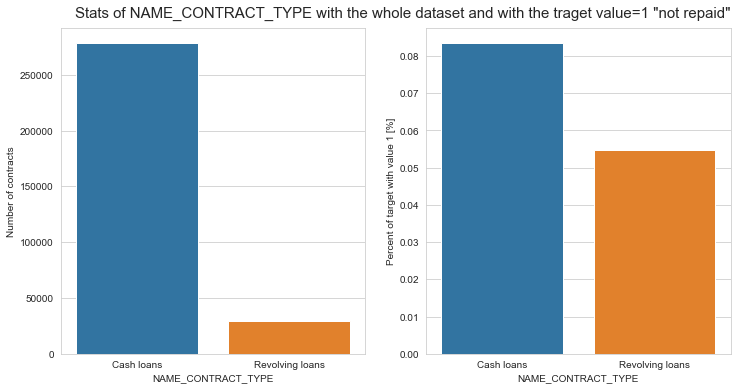

In [745]:
# Calling the function on the column
plot_stats('NAME_CONTRACT_TYPE')

- Contract type Revolving loans are just a small fraction (10%) from the total number of loans
- in the same time, a larger amount of Revolving loans, comparing with their frequency, are **not repaid**.

#### Exploring CODE_GENDER
Gender of the client

In [746]:
application_train.drop(application_train[(application_train['CODE_GENDER'] == 'XNA')].index, inplace=True)

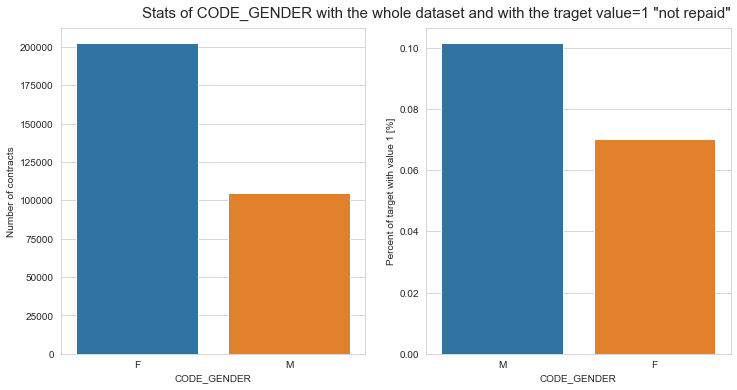

In [747]:
# Calling the function on the column
plot_stats('CODE_GENDER')

- The number of female clients is almost double the number of male clients
- Looking to the percent of unpaied credits, males have a higher chance of not returning their loans, comparing with women. 

#### Exploring FLAG_OWN_CAR
this column Flags if the client owns a car.

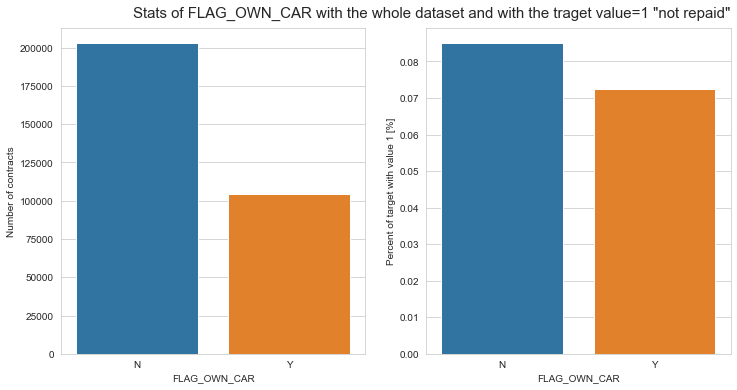

In [748]:
plot_stats("FLAG_OWN_CAR")

- The clients that owns a car are almost a half of the ones that doesn't own one.
- The clients that owns a car are more likely to repay than who doesn't.

#### Exploring NAME_FAMILY_STATUS
this column shows family status of the client.

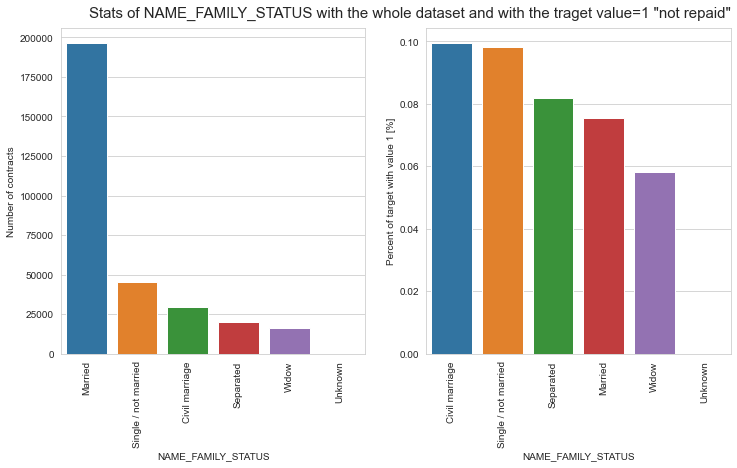

In [749]:
# calling the function with label_rotation =True
plot_stats("NAME_FAMILY_STATUS", label_rotation=True)

- Most of clients are married, followed by Single/not married and civil marriage.
- In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment.
- Widow being the most likely to pay (exception being Unknown).

-------

#### Exploring CNT_CHILDREN
this column shows Number of children the client has.

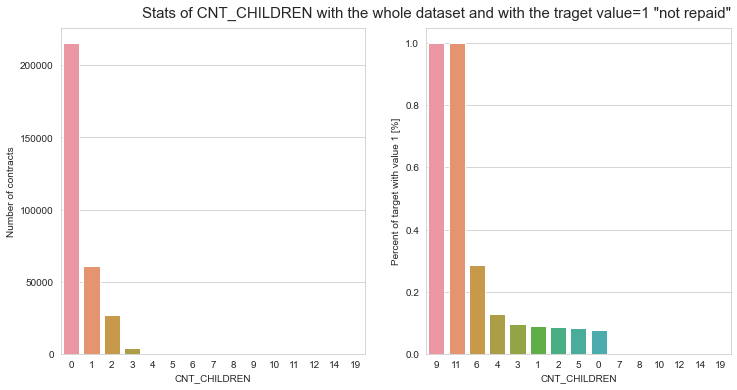

In [754]:
# calling the function 
plot_stats("CNT_CHILDREN")

- Most of the clients taking a loan have no children. 
- The number of loans associated with the clients with one children are arround 4 times smaller.
- The number of loans associated with the clients with two children are arround 8 times smaller.
- As for repayment, arround 10% clients with no children, 1, 2, 3, and 5 children have records of not repaying the loan back.
- As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

------------

#### Exploring NAME_INCOME_TYPE
this column shows the clients income type.

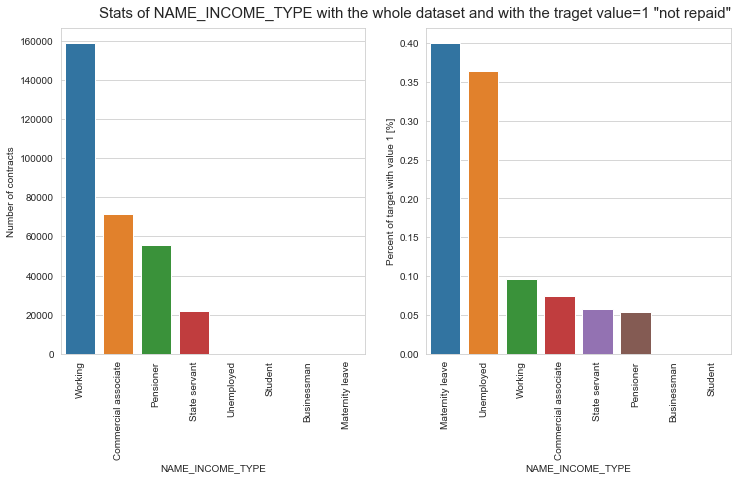

In [755]:
# calling the function 
plot_stats("NAME_INCOME_TYPE",label_rotation=True,horizontal_layout=True)

- Most of applicants for loans are income from Working, followed by Commercial associate, Pensioner and State servant.
- The applicants with the type of income Maternity leave have almost 40% ratio of not returning loans, followed by Unemployed (37%).
- The rest of types of incomes are under the average of 10% for not returning loans.

-------

#### Exploring ORGANIZATION_TYPE
this column shows the type of organization where client works.

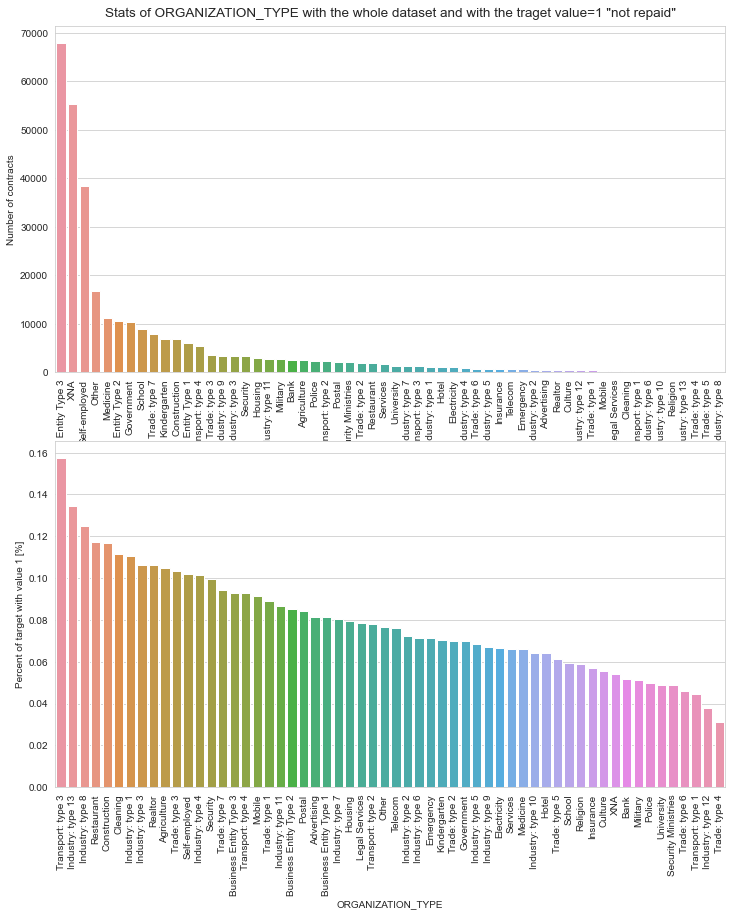

In [752]:
# calling the function 
plot_stats("ORGANIZATION_TYPE",label_rotation=True,horizontal_layout=False)

- Oraganizations with highest percent of loans not repaid are Transport: type 3 (16%), Industry: type 13 (13.5%), Industry: type 8 (12.5%) and Restaurant (less than 12%).

--------
#### Exploring NAME_HOUSING_TYPE
this column shows the What is the housing situation of the client (renting, living with parents, ...)

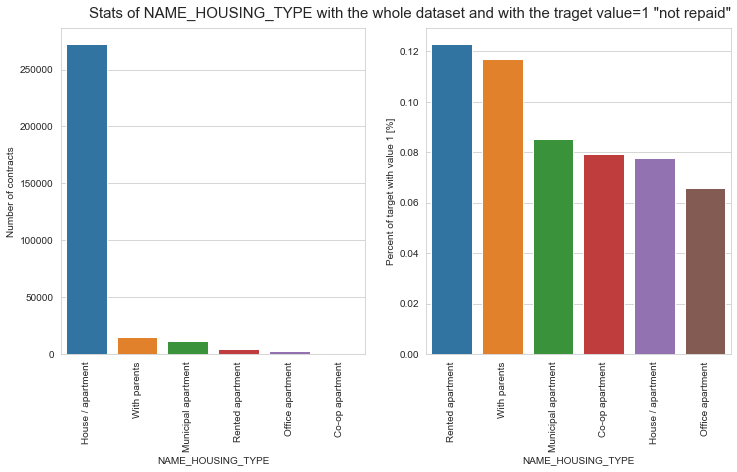

In [753]:
# calling the function 
plot_stats("NAME_HOUSING_TYPE",label_rotation=True,horizontal_layout=True)

- Over 250,000 applicants for credits registered their housing as House/apartment.
- Following categories have a very small number of clients (With parents, Municipal appartment).
- From these categories, Rented apartment and With parents have higher than 10% not-repayment rate.

-------------
### Exploring some distributions
Defining a function to easly explore numerical features.

In [453]:
# defining the function
def plot_distributions(df, feature):
    """
    This function plots a distribution of a feature.
    
    INPUTS: 
        df: a dataset.
        feature: the feature we want to plot.
    RETURNS: 
        A plot a distribution of a feature.
    """
    plt.figure(figsize=(12,5))
    sns.distplot(df[feature])
    plt.title('Distribution of %s by Target Value' % feature,  fontsize=16)

    return plt.show()

#### Explore AMT_CREDIT
This column is the Credit amount of the loan.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


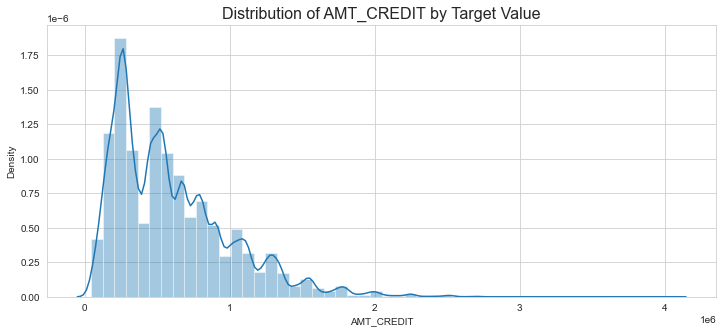

In [759]:
plot_distributions(application_train,'AMT_CREDIT')

- Data points are mostly centered in the left side of the plot **'Right skwed'** (under about 1.5 million)
- Certain models are sensitive to skewed data, so I will apply log transform to get data close to normal distribution.

#### Transforming the feature

In [760]:
# In test and train data
application_train['AMT_CREDIT'] = np.log(application_train['AMT_CREDIT'])
application_test['AMT_CREDIT'] = np.log(application_test['AMT_CREDIT'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


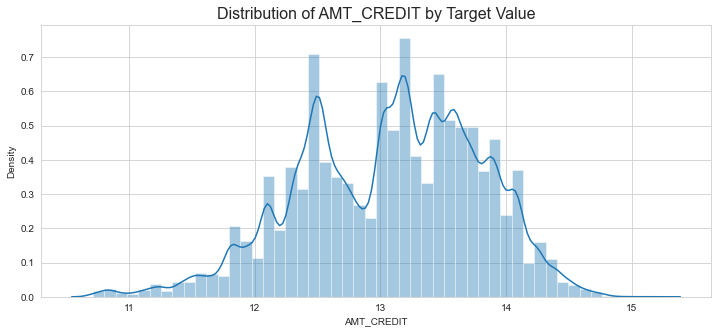

In [761]:
# Sanity check 
plot_distributions(application_train,'AMT_CREDIT')

We successfully corrected the skewness of the data

---------

#### Exploring AMT_GOODS_PRICE
It is the price of the goods for which the loan is given.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


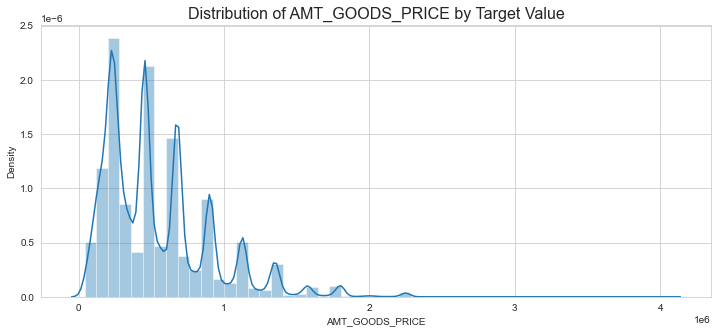

In [455]:
plot_distributions(application_train,'AMT_GOODS_PRICE')

- It looks a lot like AMT_credit which make sense because the price of the goods for which the loan is given and the loan should be approximitly near.
- In preprocessing we could check the correlation between these two features, if they are a lot like we could drop one of them.

------
#### Exploring DAYS_EMPLOYED
This column shows how many days before the application the person started current employment.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


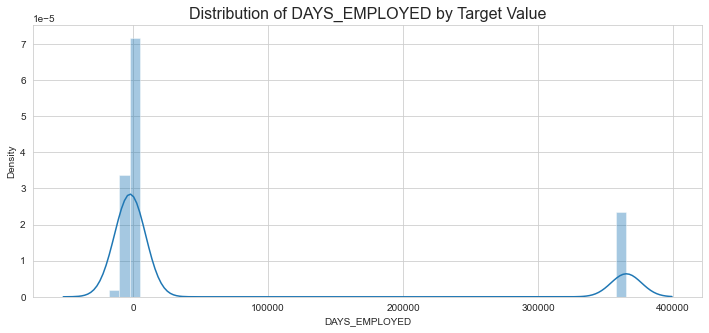

In [456]:
plot_distributions(application_train,'DAYS_EMPLOYED')

- The negative values means Days since employed and most probably these negative values means Unemployed.
- It is not clear what will be the meaning of the very large numbers at the far end (it is not realistic such a large set of people employed more than 100 years).

--------
### Comparison of interval values with TARGET = 1 and TARGET = 0
Let's compare the distribution of interval values ploted above for values of TARGET = 1 and TARGET = 0 <br>
But first I will define a function to make it easy.

In [440]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    """
    plots distribution of multiple features, with TARGET = 1/0 on the same graph.
    
    INPUTS: 
        var: A list of features names.
        nrows: no.of rows "plots" in a row.
    RETURNS: 
        plots distribution of multiple features, with TARGET = 1/0 on the same graph.
    """
    i = 0
    
    # Separting data with the target value
    t1 = application_train.loc[application_train['TARGET'] != 0]
    t0 = application_train.loc[application_train['TARGET'] == 0]
    
    # Adjusting the figure
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))
    
    # Iterating on the columns we have 
    for feature in var:
        i += 1
        plt.subplot(nrow,1,i)
        
        # ploting a kdeplot with target=1 (didn't pay)
        sns.kdeplot(t1[feature], bw_adjust=0.4,label="TARGET = 1")
        
        # ploting a kdeplot with target=0 (paid)
        sns.kdeplot(t0[feature], bw_adjust=0.4,label="TARGET = 0")
        plt.title('Distribution of %s by Target Value' % feature,  fontsize=16)
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        # showing the labels on top right of the plot
        plt.legend();
    return plt.show();

<Figure size 432x288 with 0 Axes>

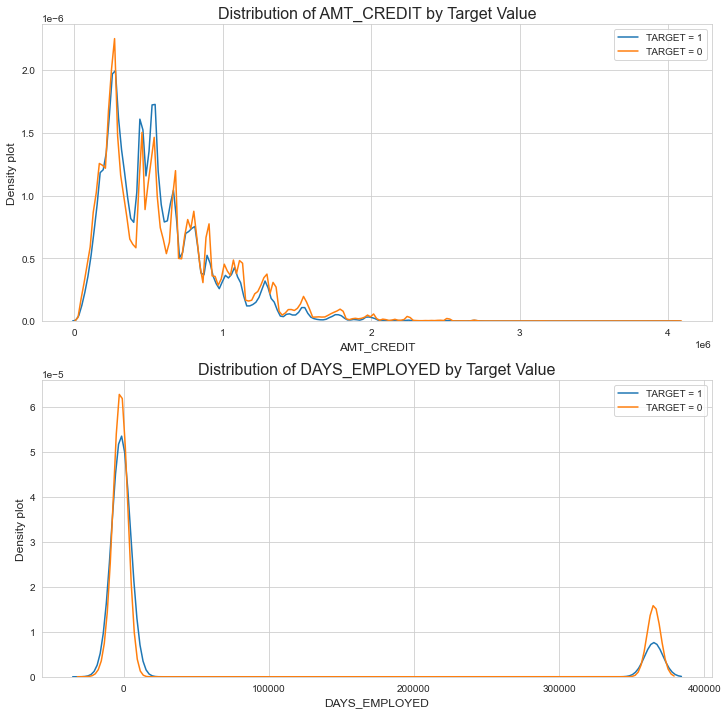

In [441]:
var = ['AMT_CREDIT','DAYS_EMPLOYED']
plot_distribution_comp(var)

- There is no significant diiferance in shape between distributions of data when target = 0 or 1.
- But in the left plot the height of the KDE is heigher and a bit thinner when target=0 (Loan paid), this maybe because are way smaller in size when target=0 and are more centered in this two regoins, but is still not clear what will be the meaning of the very large numbers at the far end (it is not realistic such a large set of people employed more than 100 years)

--------------
# Data Modeling
The approch I will take is:<br>
**I will only work on the application_train & test dataframe**
- First I will try some basic feature engineering like:
     - Encoding the categorical variables.
     - Remove anomalies (Outliers).
     - Imputing the NaN values.
     - Normalizing the features.
- And then try a baseline model to get a better vision of how well the data has preformed, and then work until it gets better.
     - After that I could try tree algorithms like (Random forest & XGboost).
     - Hyperparameters tuning of the model we see better
     
**Then If I have time I will do the following:**
- Merge app_data with previous application of clients on previous loans on Home credit nd see if it helps making the model preform better.
- Merge the bureau & bureau_balance dataframes that has historic data of applicants on previous loans at bureau and see if it helps making the model preform better or not.
- Preprocess POS_cash_balance and aggregate some statistic then merging it to the app_data.
- Also installment_payment and credit card balance.


### Encoding categorical variables.
**By using one-hot-encoder**

In [445]:
# one-hot encoding of categorical variables
# I used drop_first parameter to drop the redundant features
# So if you have K categories, it will only produce K – 1 dummy variables.

app_train = pd.get_dummies(application_train, drop_first=True)
app_test = pd.get_dummies(application_test, drop_first=True)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 230)
Testing Features shape:  (48744, 226)


#### Aligning Training and Testing Data
There need to be the same features (columns) in both the training and testing data.<br> One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data.<br> 
To remove the columns in the training data that are not in the testing data, we need to align the dataframes. 


In [449]:
# First we extract the target column from the training data
# Because this is not in the testing data but we need to keep this information.
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
# we must make sure to set axis = 1 to align the dataframes based on the columns
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in app_train
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 227)
Testing Features shape:  (48744, 226)


--------
### Remove anomalies (Outliers)
**Anomalies**<br>
These may be due to mistyped numbers, errors in measuring equipment, or they could be valid but extreme measurements.<br> One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method.
##### Treatment of the days of employment

In [450]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

- That isn't right,as we saw earlier in EDA
- The maximum value (besides being positive) is about 1000 years.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


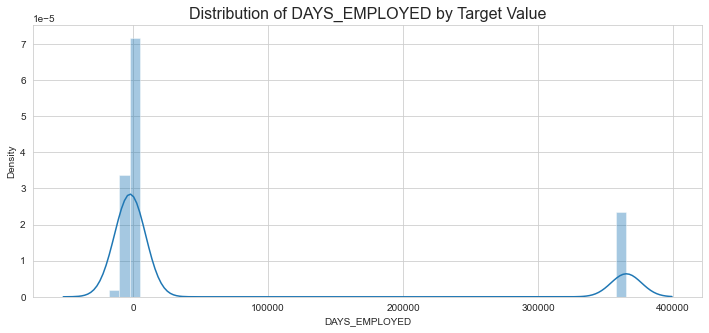

In [457]:
plot_distributions(application_train,'DAYS_EMPLOYED')

Let us figure out why and how there are so higher values of days.

In [464]:
# Printing to see how many values are in the maximum 
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
print('The number of anomaly entries are: ' , len(anom))

# let us see if it has an effect on the target value
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))


The number of anomaly entries are:  55374
The anomalies default on 5.40% of loans


- This is interesting! It turns out that the anomalies have effect on Target.
- There are differant ways to deal with anomalies (remove, or impute them),It needs a specific doman knowledge to deal with it, so i will try the safest option.
     - 1) Set the anomalies to a missing value and then have them filled in (using Imputation).
     - 2) I fill them in with the same value in case all of these loans share something in common. 
     - 3) Then create a new boolean column indicating whether or not the value was anomalous.

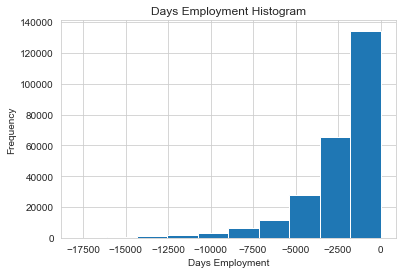

In [466]:
# Create an anomalous Bool column
app_train['DAYS_EMPLOYED_ANOMALY'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# plot them quickly
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

- The distribution looks in line with what I would expect, but we have no idea of ehat negative days mean.
- We have to fill the NaN values with the median because the data is skewed.

In [547]:
# Doing the same thing in test data.
app_test['DAYS_EMPLOYED_ANOMALY'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# Sanity check
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 228)
Testing Features shape:  (48744, 228)


---------


### Preparing the data for modeling

In [508]:
# impoting the libiries
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

Takeing a copy of train and test data

In [653]:
# Copy of the testing and training data
train = app_train.copy()
test = app_test.copy()

In [654]:
# Drop the target from the training data
train = app_train.drop(columns = ['TARGET'])

In [655]:
# Splitting the training data
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.3, random_state=1)

In [656]:
# Feature names
features = list(train.columns)

### Buliding the first part of our pipeline

In [608]:
# Buliding the first part of the pipeline
# Scaling the numeric features 
numeric_transformer= Pipeline(
    steps=[("scaler", MinMaxScaler(feature_range = (0, 1))),
            ("imputer",SimpleImputer(strategy = 'median'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features)]
)

### Baseline model
Our baseline model would be LogisticRegression

In [609]:
# Logestic classfier pipeline model
# Make the model with the specified regularization parameter
log_clf = Pipeline(
    steps= [("preprocessor", preprocessor),
    ("classifier", LogisticRegression(C = 0.0001))] # to prevent overfitting, because a lot of dimentions
)

In [610]:
# Fitting the model pipeline to our preprocessing pipeline
log_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   

## Predicting on test data we splitted


In [611]:
log_y_score = log_clf.predict_proba(X_test)[:,1]

## Evaluating our Baseline model

In [612]:
roc_auc_score(y_test, log_y_score)

0.6911343308365434

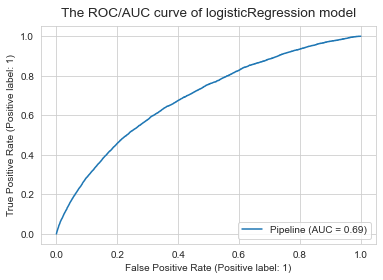

In [637]:
from sklearn import metrics
metrics.plot_roc_curve(log_clf, X_test, y_test)
plt.title('The ROC/AUC curve of logisticRegression model',loc='center',pad=10,fontsize=13.5)
plt.show()

#### Our logistic regression baseline scored around 0.691134 .

## Improved Model: Random Forest
Tring and beat the performance of our baseline,Let's try using a Random Forest on the same training data to see how that affects performance.

In [660]:
# Importing the model
from sklearn.ensemble import RandomForestClassifier

In [661]:
# Making the model pipeline
forest = Pipeline(
    steps= [("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators = 100,
                                          random_state = 50, 
                                          verbose = 1, n_jobs = -1))]

)

In [662]:
# Fitting the random forest model
forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   

## Predicting on test data we splitted with RandomForest

In [663]:
forest_y_score = forest.predict_proba(X_test)[:,1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished


## Evaluating our RandomForest model

In [664]:
roc_auc_score(y_test, forest_y_score)

0.709793374420798

### Ploting the ROC curve

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


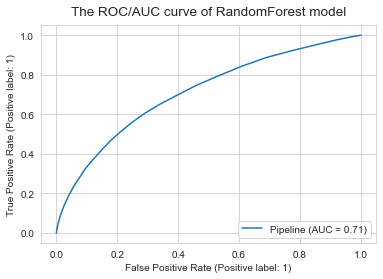

In [665]:
metrics.plot_roc_curve(forest, X_test, y_test)
plt.title('The ROC/AUC curve of RandomForest model',loc='center',pad=10,fontsize=13.5)
plt.show()

#### There is a progress while using Random forest classfier and scored around 0.709793 .


-----------------
### More Feature Engineering on Application Dataframe
- Engineering Some simple new features (percentages), and se how it is correlatedwith the target value.


In [917]:
# Copy of the testing and training data
eng_train = app_train.copy()
eng_test = app_test.copy()

# Makinthe the new features
eng_train['DAYS_EMPLOYED_PERC'] = eng_train['DAYS_EMPLOYED'] / eng_train['DAYS_BIRTH']
eng_train['INCOME_CREDIT_PERC'] = eng_train['AMT_INCOME_TOTAL'] / eng_train['AMT_CREDIT']
eng_train['INCOME_PER_PERSON'] = eng_train['AMT_INCOME_TOTAL'] / eng_train['CNT_FAM_MEMBERS']
eng_train['ANNUITY_INCOME_PERC'] = eng_train['AMT_ANNUITY'] / eng_train['AMT_INCOME_TOTAL']
eng_train['PAYMENT_RATE'] = eng_train['AMT_ANNUITY'] / eng_train['AMT_CREDIT']

## Engineering bureau dataset featrues
#### Writing a functionFunction for Numeric Aggregations


In [918]:
import warnings
warnings.filterwarnings('ignore')

def agg_numeric(df, group_var, df_name):
    """
    Aggregates to the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df: the dataframe to calculate the statistics on
        group_var: the variable by which to group df
        df_name: the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Double check on removing id variables other than grouping variable.
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df.drop(columns = col, inplace=True)
            
    
    # Selecting only numeric features
    numeric_df = df.select_dtypes('number')
    
    # Spicifing the index of the grouping variable of the whole df to the numeric df
    numeric_df[group_var] = df[group_var]

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [919]:
# Calling the functionon bureau df and calucalte some statistics
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [920]:
# Merge with with main df
eng_train = eng_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

##### Listing the correlations

In [921]:
# List of featured columns
columns = ['DAYS_EMPLOYED_PERC','DAYS_EMPLOYED_PERC','INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC','PAYMENT_RATE']
columns = columns+bureau_agg.columns.values.tolist()

In [922]:
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = eng_train['TARGET'].corr(eng_train[col])
    
    # Append the list as a tuple
    new_corrs.append((col, corr)) 
    
# Sort the correlations by the absolute value
# reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('DAYS_EMPLOYED_PERC', -0.06795454075818776),
 ('DAYS_EMPLOYED_PERC', -0.06795454075818776),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046)]

- None of the new variables have a significant correlation with the TARGET.
- But we will see how it will affect the model.
- We can look at the KDE plot of the highest correlated variable, bureau_DAYS_CREDIT_mean, with the target in in terms of absolute magnitude correlation


In [923]:
def plot_kde(var_name, df):
    
    """
    Plots the disribution of a variable colored by value of the target

    """
    
    plt.figure(figsize = (10, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name,fontsize=13);
    plt.ylabel('Density',fontsize=13);
    plt.title('%s Distribution' % var_name, fontsize=15)
    plt.legend();

    

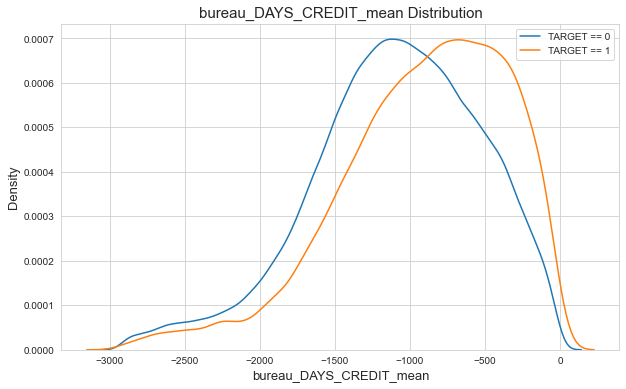

In [924]:
plot_kde('bureau_DAYS_CREDIT_mean',eng_train)

- The definition of this column is: "How many days before current application did client apply for Credit Bureau credit". 
- The larger negative number indicates the loan was further before the current loan application.
- We see an extremely weak positive relationship between the average of this variable and the target meaning that clients who applied for loans further in the past potentially are more likely to repay loans at Home Credit.
- With a correlation this weak though, it is just as likely to be noise as a signal.

### Handling categorical featues

In [925]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation of `group_var`
    
    INPUTS
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [926]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [927]:
#merging the results with rhe main df
eng_train = eng_train.merge(bureau_counts, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

---------
## Now I will engineer some features on bureau_balance dataset.
#### Writing a functionFunction for Numeric Aggregations


In [928]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [929]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


- The above dataframes have the calculations done on each loan. 
- I need to aggregate these for each client. 
- I can do this by merging the dataframes together first. 
- Then I just need to aggregate the statistics again, this time grouping by the SK_ID_CURR.

In [930]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, 
                                          right_index = True, left_on = 'SK_ID_BUREAU',
                                          how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']],
                                      on = 'SK_ID_BUREAU', how = 'left')


# calling agg_numeric function to calculate stats again for each applicant
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), 
                                       group_var = 'SK_ID_CURR', df_name = 'client')

bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


In [931]:
eng_train = eng_train.merge(bureau_by_loan, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

### Making the same enginerring for the test dataset

In [932]:
# Makinthe the new features as we did on train
eng_test['DAYS_EMPLOYED_PERC'] = eng_test['DAYS_EMPLOYED'] / eng_test['DAYS_BIRTH']
eng_test['INCOME_CREDIT_PERC'] = eng_test['AMT_INCOME_TOTAL'] / eng_test['AMT_CREDIT']
eng_test['INCOME_PER_PERSON'] = eng_test['AMT_INCOME_TOTAL'] / eng_test['CNT_FAM_MEMBERS']
eng_test['ANNUITY_INCOME_PERC'] = eng_test['AMT_ANNUITY'] / eng_test['AMT_INCOME_TOTAL']
eng_test['PAYMENT_RATE'] = eng_test['AMT_ANNUITY'] / eng_test['AMT_CREDIT']

# Merge with with main df
eng_test = eng_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

#merging the results with rhe main df
eng_test = eng_test.merge(bureau_counts, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

eng_test = eng_test.merge(bureau_by_loan, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

Aligning the two dataframes

In [933]:
# First we extract the target column from the training data
# Because this is not in the testing data but we need to keep this information.
train_labels = eng_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
# we must make sure to set axis = 1 to align the dataframes based on the columns
eng_train, eng_test = eng_train.align(eng_test, join = 'inner', axis = 1)

# Add the target back in app_train
eng_train['TARGET'] = train_labels

print('Training Features shape: ', eng_train.shape)
print('Testing Features shape: ', eng_test.shape)

Training Features shape:  (307511, 362)
Testing Features shape:  (48744, 361)


---------

## Now we are ready to see if these new features affect our model

In [935]:
# Drop the target from the training data
eng_train = eng_train.drop(columns = ['TARGET'])

In [936]:
# Splitting the training data
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(eng_train, train_labels, test_size=0.3, random_state=2)

In [943]:
# Feature names
features_eng = list(eng_train.columns)

In [944]:
# Buliding the first part of the pipeline
# Scaling the numeric features 
numeric_transformer= Pipeline(
    steps=[("scaler", MinMaxScaler(feature_range = (0, 1))),
            ("imputer",SimpleImputer(strategy = 'median'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_eng)]
)

In [960]:
# Making the model pipeline
eng_forest = Pipeline(
    steps= [("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators = 100,
                                          random_state = 50, 
                                          verbose = 1, n_jobs = -1))]

)

In [961]:
# Fitting the random forest model
eng_forest.fit(X_train_eng, y_train_eng)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SK_ID_CURR_x',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED'

## Predicting on test data we splitted with RandomForest

In [962]:
forest_y_score_eng = eng_forest.predict_proba(X_test_eng)[:,1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


## Evaluating our RandomForest model on test and train data.

In [963]:
test_score = roc_auc_score(y_test_eng, forest_y_score_eng)
print('The Score of test data is: ', test_score)

The Score of test data is:  0.7051048237166522


In [965]:
forest_y_score_eng_train = eng_forest.predict_proba(X_train_eng)[:,1]
train_score = roc_auc_score(y_train_eng, forest_y_score_eng_train)
print('The Score of train data is: ', train_score)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.3s finished


The Score of train data is:  1.0


### We have an overfitting problem
There are sevral ways to deel with overfitting
- Adding more data (Not valid option)
- Use Regularization.
- Reducing the number of features or use dimintionality reduction algorithms like PCA.

#### I will try Regularization

In [968]:
# Making Regularized model pipeline
eng_forest_reg = Pipeline(
    steps= [("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators = 200,
                                          random_state = 50,
                                          max_features='sqrt', #This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, 
                                          max_depth=5, # This will reduce the complexity of the learned models, lowering over fitting risk.
                                          min_samples_leaf=5, # This has a similar effect to the max_depth parameter
                                          verbose = 1, n_jobs = -1))]
)
# Fitting the random forest model
eng_forest_reg.fit(X_train_eng, y_train_eng)

# Evaluating on train and test data
forest_y_score_eng_reg = eng_forest_reg.predict_proba(X_test_eng)[:,1]
test_score_reg = roc_auc_score(y_test_eng, forest_y_score_eng_reg)
forest_y_score_eng_train_reg = eng_forest_reg.predict_proba(X_train_eng)[:,1]
train_score_reg = roc_auc_score(y_train_eng, forest_y_score_eng_train_reg)

print('The Score of test data is: ', test_score_reg)
print('The Score of train data is: ', train_score_reg)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   43.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


The Score of test data is:  0.7199247210546321
The Score of train data is:  0.7322204079587495


### Ploting the ROC curve

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished


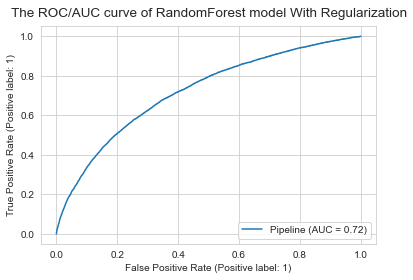

In [970]:
metrics.plot_roc_curve(eng_forest_reg, X_test_eng, y_test_eng)
plt.title('The ROC/AUC curve of RandomForest model With Regularization',loc='center',pad=10,fontsize=13.5)
plt.show()

#### We Solved the overfitting problem and There is a progress while using Random forest classfier and scored around 0.72 .


In [971]:
pro_X_train_eng = preprocessor.fit_transform(X_train_eng)

## Hyperparametar Tunning

In [972]:
# param_grid = {
#  'max_depth': [10, 30, 60, 70, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [2, 4],
#  'min_samples_split': [2, 5],
#  'criterion' :['gini', 'entropy'],            
#  'n_estimators': [50,100, 500, 1000, 1500]}

param_grid = {
 'max_depth': [5, 3],
  'min_samples_leaf': [5,3],
  'max_features': ['auto', 'sqrt'],
 'n_estimators': [100,150,200]}

In [973]:
# search of parameters, using 3 fold cross validation, 
from sklearn.model_selection import GridSearchCV

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(
                                          random_state = 50, 
                                          criterion = 'gini',
                                          verbose = 1, n_jobs = -1),param_grid=param_grid, cv= 3)
CV_rfc.fit(pro_X_train_eng, y_train_eng)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.8s finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=50,
                                              verbose=1),
             param_grid={'max_depth': [5, 3], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 3],
                         'n_estimators': [100, 150, 200]})

In [974]:
CV_rfc.best_params_


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 100}

## Feature Importance

In [980]:
# GEtting Feature Impotance
F_E_values = eng_forest_reg['classifier'].feature_importances_

# Make the feature importance dataframe
feature_importances = pd.DataFrame({'feature': features_eng, 'importance': F_E_values})

In [993]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model.  
    
        
    """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:25]))), 
            df['importance_normalized'].head(25), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:25]))))
    ax.set_yticklabels(df['feature'].head(25))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    
    
    return plt.show()

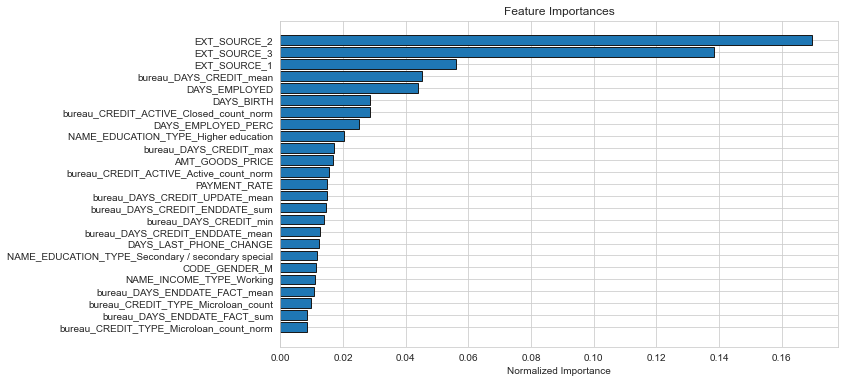

In [994]:
plot_feature_importances(feature_importances)

### Observations: 
- The most important features are Normalized score from external data source.
- Most of Importan features are the ones I engineered.

---------

# Conclusion:

- Home credit can quite rely on this model as a **secondary option** for now as it needs further enhancements.
- Home credit should consider these advices before lending money to applicants.
    - Beware when contract type is **revolving** as a larger amount of Revolving loans,                                       comparing with their frequency, are **not repaid**.
    - **Widowed** have the **most repayment rate** so there should be more assurance when lending them.
    - Should focus on applicants with **no children & (1: 2 children)** as they are most frequent                                                     and with **highest repayment rate**.
    - **Shouldn’t** lend to applicants with **9** and **12** children as **100%** of them **don't repay**.
    - Pay attention when someone **isn't working** or on maturity leave as **40%** of them **doesn’t pay back**.


------------
# Next steps
## For EDA .
- Explore the bereau dataset.
    - Merge the application_train and bureau on ID column
    - Explore these features (Credit status, Credit currency, Credit type, Duration of credit, Credit overdue 'CREDIT_DAY_OVERDUE', Credit sum 'AMT_CREDIT_SUM')
    - Remove the outliers from AMT_CREDIT_SUM and better plot the distribution.
- Explore the Previous application data 
    - Plot these features ( Contract type, Cash loan purpose, Contract status, Payment type,Client type)

## For Feature engineering.
- Develope new features from the categorical and numeric column from<br> (Previous_application, POS_CASH_BALANCE,Installments,Credit_card_balance) datasets.
- Then merge the to application data (Train & test)
- Evaluate the model on these new features.

## For Dimentionality reduction.
- Get important features from Randomforest
- Select top features and evaluate.
- If It preforms poorly i coud add more feature untill it gets better.

## For Data Modeling
- I want to try somoe Gradiant boosting algorithms like XGBoost, and LightGBM.
- I think it will preform even better than Randomforest.
-------
Amir Helmy